In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from scipy.stats import norm

In [3]:
%config InlineBackend.figure_format = 'svg'

In [4]:
def plot(listA, listB, xlabel='', ylabel='', EvsE = True):
    fig = plt.figure(figsize=(7,7))
    plt.scatter(listA, listB, s=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if(EvsE):
        axes = plt.gca()    
        axes.set_xlim([0,350])
        axes.set_ylim([0,350])
        plt.axline((150,150), (400,400))

def color2Dplot(x, y, z, xlabel='', ylabel='', zlabel='', title=''):
    plt.figure(figsize=(10,6))
    points = plt.scatter(x, y, c=z, cmap='jet',lw=0, s=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(points)
    cbar.set_label(zlabel)
    
def MakeDataFrame(inputFile):
    f = uproot.open(inputFile)
    tree = f[inputFile.split('/')[-1].replace('.root','')]
    df = tree.arrays(library="pd")
    df['GenFullEnergy_1'] = df['GenEnergy_1']*np.cosh(df['GenEta_1'])
    df['GenFullEnergy_2'] = df['GenEnergy_2']*np.cosh(df['GenEta_2'])
    
    return df

def getEdges(distFromEdge):
    """
    distFromEdge is the number of eta bins to discard from high and low eta edge of the HGC
    """
    EtaCutHigh = (35 - distFromEdge) * 0.087
    EtaCutLow = (15 + distFromEdge) * 0.087
    return(EtaCutLow, EtaCutHigh)

In [5]:
df_WithSplit = MakeDataFrame('varsDir/vars_VBFHToTauTau_200PU_WithEnergySplit.root')
df_NoSplit = MakeDataFrame('varsDir/vars_VBFHToTauTau_200PU_NoEnergySplit.root')

In [6]:
df_WithSplit_3binsfromEdge_1 = df_WithSplit[(abs(df_WithSplit['GenEta_1'])>getEdges(3)[0]) & (abs(df_WithSplit['GenEta_1'])<getEdges(3)[1])]
df_NoSplit_3binsfromEdge_1 = df_NoSplit[(abs(df_NoSplit['GenEta_1'])>getEdges(3)[0]) & (abs(df_NoSplit['GenEta_1'])<getEdges(3)[1])]

df_WithSplit_0binsfromEdge_1 = df_WithSplit[(abs(df_WithSplit['GenEta_1'])>getEdges(0)[0]) & (abs(df_WithSplit['GenEta_1'])<getEdges(0)[1])]
df_NoSplit_0binsfromEdge_1 = df_NoSplit[(abs(df_NoSplit['GenEta_1'])>getEdges(0)[0]) & (abs(df_NoSplit['GenEta_1'])<getEdges(0)[1])]

In [7]:
df_With = df_WithSplit_3binsfromEdge_1
df_No = df_NoSplit_3binsfromEdge_1

In [8]:
###############Energy#####

In [9]:
thresholds = np.array([20, 40, 60, 80, 100, 120, 150, 180])
midEnergies = np.array([ 0.5*(thresholds[i]+thresholds[i+1]) for i in range(len(thresholds)-1)])
errEnergies = np.array([ midEnergies[i]-thresholds[i] for i in range(len(midEnergies))])

In [10]:
variables = ['EtTot1x1_1', 'EtTot3x3_1', 'EtTot5x5_1', 'EtTot7x7_1']
for mydf in ['df_With', 'df_No']:
    for var in variables:
        exec("dic" + mydf + var + " = {'mean':[], 'std':[]}")
        exec("dicRatio" + mydf + var + " = {'mean':[], 'std':[]}")
        for i in range(len(thresholds)-1):
            exec("data = "+mydf+"[("+mydf+"['GenEnergy_1']>thresholds[i]) & ("+mydf+"['GenEnergy_1']<thresholds[i+1])]")
            exec("dic" + mydf + var + "['mean'].append(data[var].mean())")
            exec("dic" + mydf + var + "['std'].append(data[var].std())")
            exec("dicRatio" + mydf + var + "['mean'].append((data[var]/data['GenEnergy_1']).mean())")
            exec("dicRatio" + mydf + var + "['std'].append((data[var]/data['GenEnergy_1']).std())")

In [11]:
def labelCreator(dfName, varName):
    if dfName=='df_With':
        return 'With splitting: '+varName.replace('EtTot','').replace('_1','')
    elif dfName=='df_No':
        return 'Without splitting: '+varName.replace('EtTot','').replace('_1','')
    else:
        print('data frame name wrong!!!!!!!')
        sys.exit(1)

def scatterPlotCompare(dataFrames, variables, yUpLim=250):
    fig = plt.figure(figsize=(6,6))
    alphaC=1
    
    
    for var in reversed(variables):
        offSet=-1
        for mydf in dataFrames:
            exec("plt.errorbar(midEnergies+offSet, dic"+mydf+var+"['mean'], xerr=errEnergies, yerr=dic"+mydf+var+"['std'], label=labelCreator('"+mydf+"','"+var+"'), alpha=alphaC)")
            offSet += 2
        
    markersize = 3
    alphaD=0.7
    for mydf in dataFrames:
        for var in reversed(variables):
            exec("plt.scatter("+mydf+"['GenEnergy_1'], "+mydf+"['"+var+"'],s=markersize, alpha=alphaD)")
    
    plt.xlabel('Gen $E_T$ [GeV]')
    plt.ylabel('Reco $E_T$ [GeV]')
    axes = plt.gca()    
    axes.set_xlim([15,185])
    axes.set_ylim([-8,yUpLim])
    plt.axline((150,150), (550,550), linestyle=":", color='black', label='Reco $E_T$=Gen $E_T$ border')
    plt.legend(loc='upper left', fontsize=12)

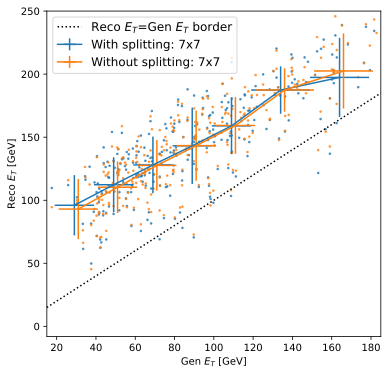

In [12]:
scatterPlotCompare(['df_With', 'df_No'], ['EtTot7x7_1'])

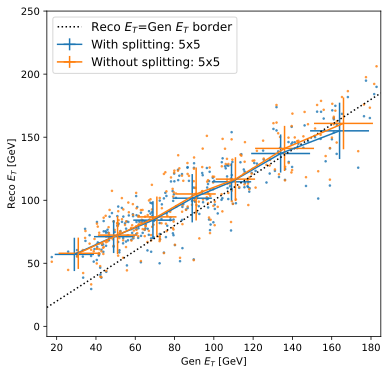

In [13]:
scatterPlotCompare(['df_With', 'df_No'], ['EtTot5x5_1'])

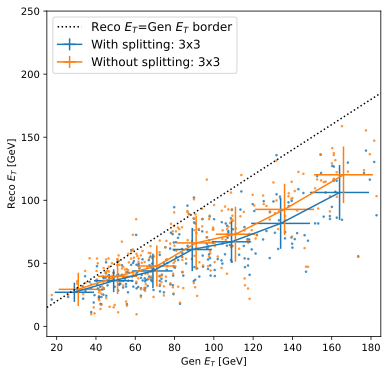

In [14]:
scatterPlotCompare(['df_With', 'df_No'], ['EtTot3x3_1'])

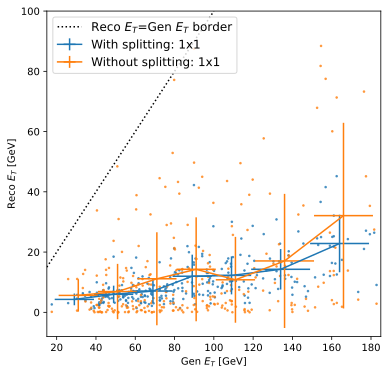

In [15]:
scatterPlotCompare(['df_With', 'df_No'], ['EtTot1x1_1'], yUpLim=100)

In [ ]:
####################################ETA########################

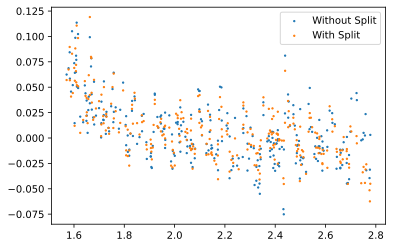

In [16]:
alphaA=1
plt.scatter(abs(df_No['GenEta_1']), (abs((df_No['EtaTot7x7_1']-35.5)*0.087) - abs(df_No['GenEta_1'])), s=2, label='Without Split', alpha=alphaA)
plt.scatter(abs(df_With['GenEta_1']), (abs((df_With['EtaTot7x7_1']-35.5)*0.087) - abs(df_With['GenEta_1'])), s=2, label='With Split', alpha=alphaA)
plt.legend()

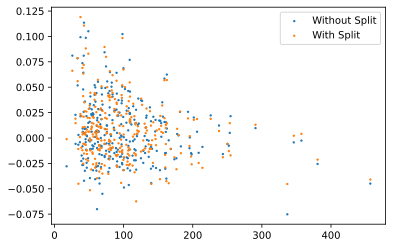

In [17]:
alphaA=1
plt.scatter(abs(df_No['GenEnergy_1']), (abs((df_No['EtaTot7x7_1']-35.5)*0.087) - abs(df_No['GenEta_1'])), s=2, label='Without Split', alpha=alphaA)
plt.scatter(abs(df_With['GenEnergy_1']), (abs((df_With['EtaTot7x7_1']-35.5)*0.087) - abs(df_With['GenEta_1'])), s=2, label='With Split', alpha=alphaA)
plt.legend()

In [18]:
#color2Dplot(abs(df_No['GenEta_1']), abs(df_No['GenEnergy_1']), (abs((df_No['EtaTot7x7_1']-35.5)*0.087) - abs(df_No['GenEta_1'])))
#color2Dplot(abs(df_With['GenEta_1']), abs(df_With['GenEnergy_1']), (abs((df_With['EtaTot7x7_1']-35.5)*0.087) - abs(df_With['GenEta_1'])))



In [19]:
df_No_etaCut = df_No[abs(df_No['GenEta_1'])>1.85]
df_With_etaCut = df_With[abs(df_With['GenEta_1'])>1.85]

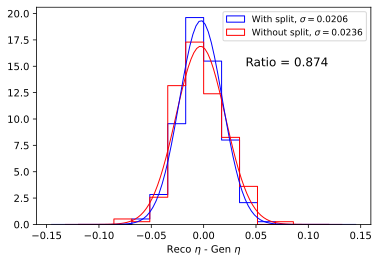

In [20]:
alphaA=1
binsC=np.linspace(-0.12,0.12,15)
densityC = True
x_No = abs((df_No_etaCut['EtaTot7x7_1']-35.5)*0.087) - abs(df_No_etaCut['GenEta_1'])
x_With = abs((df_With_etaCut['EtaTot7x7_1']-35.5)*0.087) - abs(df_With_etaCut['GenEta_1'])

mu_No, std_No = norm.fit(x_No)
mu_With, std_With = norm.fit(x_With)

color_No = 'red'
color_With = 'blue'

plt.hist(x_With, label='With split, $\sigma=$'+str(round(std_With, 4)), alpha=alphaA, histtype='step', bins=binsC, density=densityC, color=color_With)
plt.hist(x_No, label='Without split, $\sigma=$'+str(round(std_No, 4)), alpha=alphaA, histtype='step', bins=binsC, density=densityC, color=color_No)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_No, std_No)
plt.plot(x, p, color_No, linewidth=1)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_With, std_With)
plt.plot(x, p, color_With, linewidth=1)
plt.text(0.04, 15, 'Ratio = '+str(round(std_With/std_No,3)), fontsize=12)
plt.xlabel('Reco $\eta$ - Gen $\eta$')
plt.legend(loc='upper right', fontsize=9)



In [21]:
##############################PHI##############

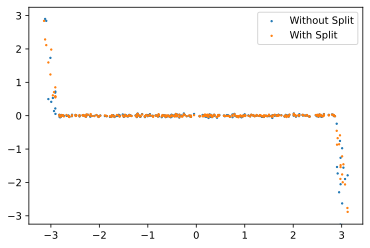

In [22]:
alphaB=1
plt.scatter(df_No['GenPhi_1'], (df_No['PhiTot7x7_1']*math.pi/36-(36.5/36.)*math.pi - df_No['GenPhi_1']), s=2, label='Without Split', alpha=alphaB)
plt.scatter(df_With['GenPhi_1'], (df_With['PhiTot7x7_1']*math.pi/36-(36.5/36.)*math.pi - df_With['GenPhi_1']), s=2, label='With Split', alpha=alphaB)
axes = plt.gca()
axes.set_ylim([-3.25,3.25])
plt.legend()

### The artifact above is understood. On the edges when averageing top most (72) and bottom most (1) bins, it becomes ~35 and could be any other numbers in between

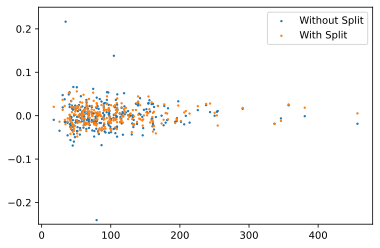

In [23]:
alphaB=1
plt.scatter(df_No['GenEnergy_1'], (df_No['PhiTot7x7_1']*math.pi/36-(36.5/36.)*math.pi - df_No['GenPhi_1']), s=2, label='Without Split', alpha=alphaB)
plt.scatter(df_With['GenEnergy_1'], (df_With['PhiTot7x7_1']*math.pi/36-(36.5/36.)*math.pi - df_With['GenPhi_1']), s=2, label='With Split', alpha=alphaB)
axes = plt.gca()
axes.set_ylim([-.25,.25])
plt.legend()

In [24]:
df_No_phiCut = df_No[abs(df_No['GenPhi_1'])<2.85]
df_With_phiCut = df_With[abs(df_With['GenPhi_1'])<2.85]

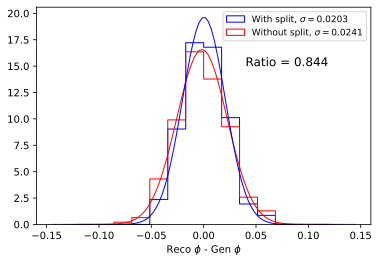

In [25]:
alphaA=1
binsC=np.linspace(-0.12,0.12,15)
densityC = True
x_No = df_No_phiCut['PhiTot7x7_1']*math.pi/36-(36.5/36.)*math.pi - df_No_phiCut['GenPhi_1']
x_With = df_With_phiCut['PhiTot7x7_1']*math.pi/36-(36.5/36.)*math.pi - df_With_phiCut['GenPhi_1']

mu_No, std_No = norm.fit(x_No)
mu_With, std_With = norm.fit(x_With)

color_No = 'red'
color_With = 'blue'

plt.hist(x_With, label='With split, $\sigma=$'+str(round(std_With, 4)), alpha=alphaA, histtype='step', bins=binsC, density=densityC, color=color_With)
plt.hist(x_No, label='Without split, $\sigma=$'+str(round(std_No, 4)), alpha=alphaA, histtype='step', bins=binsC, density=densityC, color=color_No)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_No, std_No)
plt.plot(x, p, color_No, linewidth=1)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_With, std_With)
plt.plot(x, p, color_With, linewidth=1)
plt.text(0.04, 15, 'Ratio = '+str(round(std_With/std_No,3)), fontsize=12)
plt.xlabel('Reco $\phi$ - Gen $\phi$')
plt.legend(loc='upper right', fontsize=9)
